In [1]:
%cd /home/jnyborg/git/semi-mark

import pickle as pkl

import json
import os
import random
from copy import deepcopy

import numpy as np
import seaborn as sns
import torch
from torchvision.transforms import Compose

from torch.utils import data
from tqdm import tqdm
from dataset import PixelSetData, GroupByShapesBatchSampler
from eval import evaluation
from utils.train_utils import to_cuda
from psetae.models.mark import Mark
from transforms import Normalize, ToTensor, RandomSamplePixels
from utils import label_utils
import torch.nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch.nn.functional as F

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

blocks = random.sample(list(range(100)), k=20)

/home/jnyborg/git/semi-mark


## Setup model and load weights

In [2]:
device = torch.device('cuda:0')
def get_model(model_dir='outputs/pseltae_32VNH', fold_num=0):
    fold_dir = os.path.join(model_dir, f'fold_{fold_num}')
    best_model_path = os.path.join(fold_dir, 'model.pt')

    with open(os.path.join(model_dir, 'train_config.json')) as f:
        config = json.load(f)

    model = Mark(input_dim=config["input_dim"], n_classes=len(classes))

    model.to(device)
    model.load_state_dict(torch.load(best_model_path)['state_dict'])
    model.eval()
    print('Restored model weights from', best_model_path)

    return model

In [3]:
classes = ['corn', 'horsebeans', 'meadow', 'spring_barley', 'spring_oat', 'spring_peas', 'spring_wheat', 'unknown', 'winter_barley', 'winter_rapeseed', 'winter_rye', 'winter_triticale', 'winter_wheat']

transform = Compose([
    RandomSamplePixels(64),  # speedup, but random
    Normalize(),
    ToTensor()
])


dataset_dk = PixelSetData('/media/data/mark_pixels', 'denmark/32VNH/2017', classes=classes, transform=transform)
dataset_fr = PixelSetData('/media/data/mark_pixels', 'france/30TXT/2017', classes=classes, transform=transform)


In [4]:
@torch.no_grad()
def get_doy_shift_result(model, dataset, doy_shifts=[-40, -20, -10, -5, 0, 5, 10, 20, 40], n_batches=100):
    data_loader = torch.utils.data.DataLoader(dataset, num_workers=8, batch_size=128, shuffle=True)
    y_true, y_pred = [], [[] for _ in doy_shifts]
    softmaxes = [[] for _ in doy_shifts]

    model.eval()
    for i, sample in enumerate(tqdm(data_loader, total=n_batches)):
        if i == n_batches:
            break
        target = sample['label']
        y_true.extend(target.tolist())

        pixels, valid_pixels, positions = to_cuda(sample, device)
        spatial_features = model.spatial_encoder(pixels, valid_pixels)

        for idx, doy_shift in enumerate(doy_shifts):
            temporal_features = model.temporal_encoder(spatial_features, positions+doy_shift)
            logits = model.classifier(temporal_features)
            probs = F.softmax(logits, dim=1)
            y_pred[idx].extend(probs.argmax(1).tolist())
            softmaxes[idx].extend(probs.tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    softmaxes = np.array(softmaxes)
    
    return y_true, y_pred, softmaxes

## Get predictions



In [5]:
model_name = 'outputs/pseltae_32VNH'
doy_shifts = list(range(-60, 61))

fold_num = 0
fold_result = []
y_true, y_pred, softmaxes = get_doy_shift_result(get_model(model_name, fold_num=fold_num), dataset_fr, doy_shifts, n_batches=100)
fold_result.append((y_true, y_pred, softmaxes))
print('done')

  0%|          | 0/100 [00:00<?, ?it/s]

Restored model weights from outputs/pseltae_32VNH/fold_0/model.pt


100%|██████████| 100/100 [00:32<00:00,  3.06it/s]

done


## Compute scores

In [21]:
def min_max_normalize(x):
    return (x - x.min()) / x.ptp()
data_rows = []

fold_shift_f1s = []
fold_shift_accs = []
for fold_num in range(1):
    shift_acc = [np.mean(y_true == pred) for pred in y_pred]
    shift_f1 = [f1_score(y_true, pred, average='macro') for pred in y_pred]
    
    fold_shift_f1s.append(shift_f1)
    fold_shift_accs.append(shift_acc)
    
    y_true, y_pred, softmaxes = fold_result[fold_num]
    
    p_yx = np.moveaxis(softmaxes, 0, 1) # (N, n_shifts, n_classes)
    p_y = p_yx.mean(axis=0)  # (n_shifts, n_classes)
    
    inception_score = np.exp(np.mean(np.sum(p_yx * (np.log(p_yx + 1e-5) - np.log(p_y[np.newaxis] + 1e-5)), axis=2), axis=0))  # (n_shifts)
    inception_score = min_max_normalize(inception_score)
    
    entropy = np.mean(np.sum(-p_yx * np.log(p_yx + 1e-5), axis=2), axis=0)
    
    # actual distribution
    target_labels = dataset_fr.get_labels()
    c_train = np.bincount(target_labels, minlength=len(classes)) / len(target_labels)
    kl_d = np.sum(c_train * (np.log(c_train + 1e-5) - np.log(p_y + 1e-5)), axis=1)
    am_score_actual = kl_d + entropy 
    am_score_actual = min_max_normalize(am_score_actual)

    # estimated
    target_labels = y_pred[np.argmax(inception_score)]
    c_train = np.bincount(target_labels, minlength=len(classes)) / len(target_labels)
    kl_d = np.sum(c_train * (np.log(c_train + 1e-5) - np.log(p_y + 1e-5)), axis=1)
    am_score_estimated = kl_d + entropy 
    am_score_estimated = min_max_normalize(am_score_estimated)
    
    entropy = min_max_normalize(entropy)
    
    for i, shift in enumerate(doy_shifts):
        data_rows.append((fold_num, shift, shift_acc[i], r'Accuracy$\uparrow$'))
        #data_rows.append((fold_num, shift, shift_f1[i], 'F1'))
        data_rows.append((fold_num, shift, entropy[i], r'Entropy$\downarrow$'))
        data_rows.append((fold_num, shift, inception_score[i], r'IS$\uparrow$'))
        data_rows.append((fold_num, shift, am_score_estimated[i], r'AM$\downarrow$'))
        #data_rows.append((fold_num, shift, am_score_actual[i], 'am score actual'))
    
df = pd.DataFrame(data_rows, columns=['fold', 'shift', 'score', 'metric'])

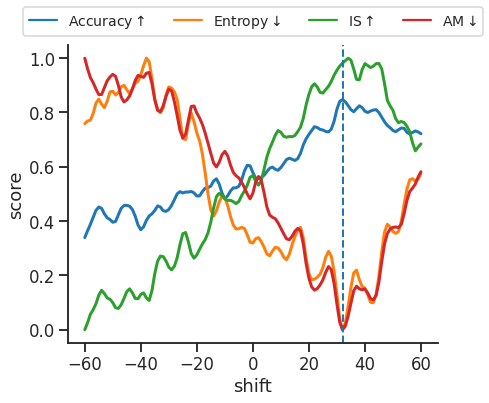

In [22]:
#### sns.set_theme()
sns.set_style('ticks')
sns.set_context('talk', rc={'text.usetex': True})

plt.figure(figsize=(7, 6))
g = sns.lineplot(data=df, x='shift', y='score', hue='metric', linewidth=3)
#plt.axvline(x=doy_shifts[np.argmax(np.mean(fold_shift_f1s, axis=0))], color='k', linestyle='--') 
g.axvline(x=doy_shifts[np.argmax(np.mean(fold_shift_accs, axis=0))], color=sns.color_palette()[0], linestyle='--', linewidth=2) 
#g.axvline(x=doy_shifts[np.argmax(np.mean(fold_shift_f1s, axis=0))], color=sns.color_palette()[0], linestyle='--', linewidth=1, label='Best shift') 
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=14)  
sns.despine()

plt.tight_layout()
plt.savefig('shift_score.pdf')
plt.show()


## Estimated shift during training

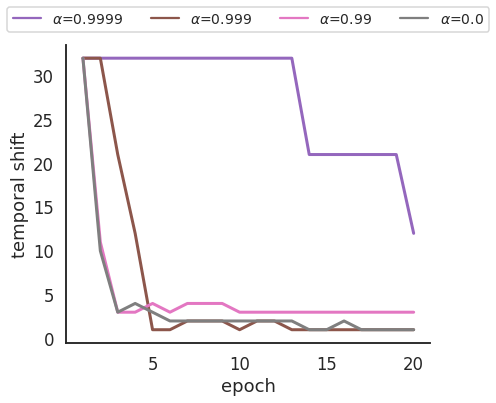

In [8]:
data_dict = {
    r'$\alpha$=0.9999': [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 12.0],
    r'$\alpha$=0.999':[32.0, 32.0, 21.0, 12.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ,
    r'$\alpha$=0.99': [32.0, 11.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
    r'$\alpha$=0.0': [32.0, 10.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0],

    
}

data_rows = []
for k, vs in  data_dict.items():
    data_rows.extend([(k, epoch+1, v) for epoch, v in enumerate(vs)])
shift_during_training = pd.DataFrame(data_rows, columns=['method', 'epoch', 'temporal shift'])

sns.set_style('white')
sns.set_context('talk', rc={'text.usetex': True})

plt.figure(figsize=(7, 6))
palette = sns.color_palette(n_colors=8)[4:]

g = sns.lineplot(data=shift_during_training, x='epoch', y='temporal shift', hue='method', linewidth=3, palette=palette)
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=14)  
#g.legend(fontsize=12)  
#g.set_xticks(np.arange(1, 20, step=2)+1)
sns.despine()
plt.tight_layout()
plt.savefig('shift_epoch.pdf')
plt.show()

 


In [9]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [10]:
p_yx = np.moveaxis(softmaxes, 0, 1) # (N, n_shifts, n_classes)
p_y = p_yx.mean(axis=0)  # (n_shifts, n_classes)



test some stuff

NameError: name 'am_score' is not defined

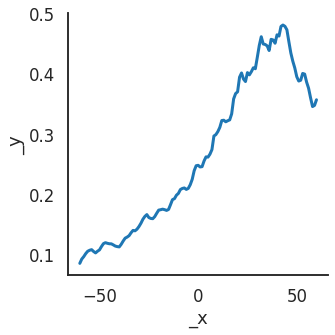

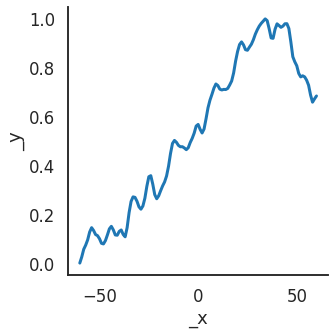

In [11]:
sns.relplot(x=doy_shifts, y=shift_f1, kind='line', linewidth=3)
sns.relplot(x=doy_shifts, y=inception_score, kind='line', linewidth=3)
sns.relplot(x=doy_shifts, y=am_score, kind='line', linewidth=3)
sns.relplot(x=doy_shifts, y=entropy, kind='line', linewidth=3)
#sns.relplot(data=res_classwise, x='doy_shift', y='f1', hue='label', kind='line', col='country', linewidth=3)
#sns.relplot(data=res_overall, x='doy_shift', y='value', hue='metric', kind='line', col='country', linewidth=3)


## France baseline

In [ ]:
model_name = 'outputs/baseline_fr'
doy_shifts = np.linspace(-60, 60, 21, dtype=int)
res_dk = get_doy_shift_result(get_model(model_name), dataset_dk, model_name, doy_shifts)
res_fr = get_doy_shift_result(get_model(model_name), dataset_fr, model_name, doy_shifts)
res_dk['country'] = 'denmark'
res_fr['country'] = 'france'
data_baseline_fr = pd.concat([res_dk, res_fr])

In [ ]:
sns.relplot(data=data_baseline_fr, x='doy_shift', y='f1', hue='label', kind='line', col='country', linewidth=3)
#

## MME

In [ ]:
model_name = 'outputs/mme'
doy_shifts = np.linspace(-60, 60, 21, dtype=int)
res_dk = get_doy_shift_result(get_model(model_name), dataset_dk, model_name, doy_shifts)
res_fr = get_doy_shift_result(get_model(model_name), dataset_fr, model_name, doy_shifts)
res_dk['country'] = 'denmark'
res_fr['country'] = 'france'
data_mme = pd.concat([res_dk, res_fr])

In [ ]:
sns.relplot(data=data_mme, x='doy_shift', y='f1', hue='label', kind='line', col='country', linewidth=3)


In [ ]:
## Upperbound DK+FR

In [ ]:

model_name = 'outputs/upperbound_dkfr'
doy_shifts = np.linspace(-60, 60, 21, dtype=int)
res_dk = get_doy_shift_result(get_model(model_name), dataset_dk, model_name, doy_shifts)
res_fr = get_doy_shift_result(get_model(model_name), dataset_fr, model_name, doy_shifts)
res_dk['country'] = 'denmark'
res_fr['country'] = 'france'
data = pd.concat([res_dk, res_fr])

In [ ]:
sns.relplot(data=data, x='doy_shift', y='f1', hue='label', kind='line', col='country', linewidth=3)

## Toulouse result

In [ ]:
model_name = 'outputs/baseline_dk'
doy_shifts = np.linspace(-20, 80, 21, dtype=int)
res_toulouse = get_doy_shift_result(get_model(model_name), dataset_toulouse, model_name, doy_shifts)


In [ ]:
sns.relplot(data=res_toulouse, x='doy_shift', y='f1', hue='label', kind='line', linewidth=3)